# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [25]:
pip install tensorflow


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [27]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [28]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [29]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [30]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [31]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [32]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [33]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Activation: relu



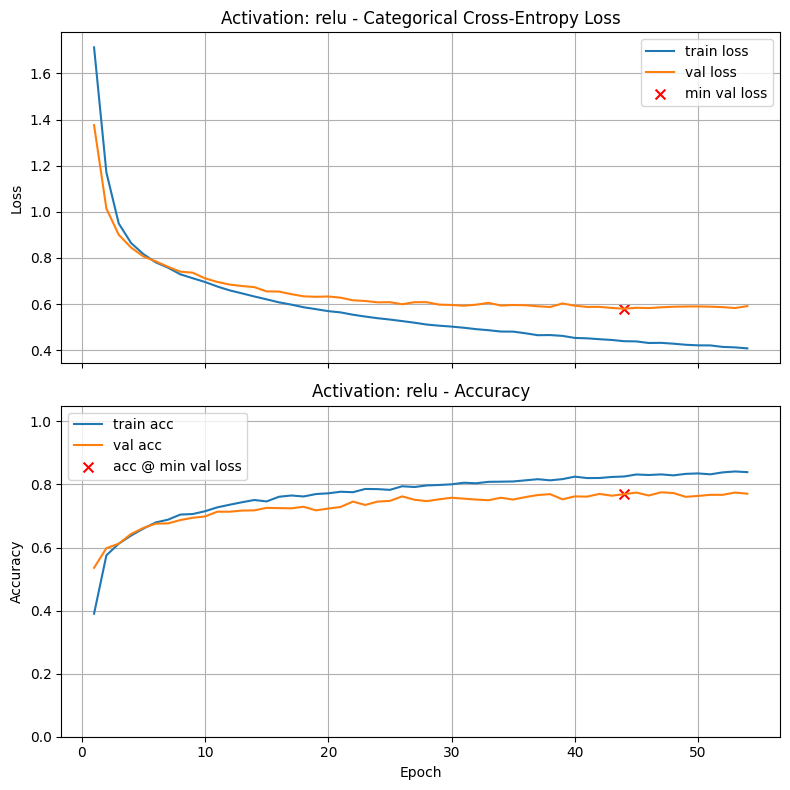

Final Training Loss:            0.4078
Final Training Accuracy:        0.8390
Final Validation Loss:          0.5911
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5797 (Epoch 44)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.6131
Test Accuracy: 0.7536

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:09

Activation: sigmoid



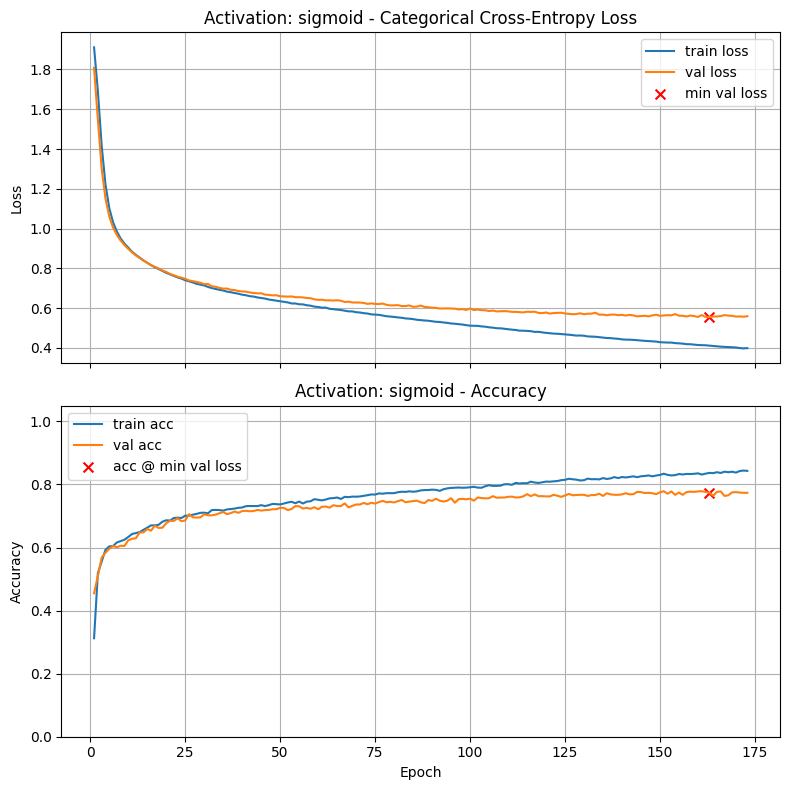

Final Training Loss:            0.3992
Final Training Accuracy:        0.8431
Final Validation Loss:          0.5598
Final Validation Accuracy:      0.7736
Minimum Validation Loss:        0.5552 (Epoch 163)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.5802
Test Accuracy: 0.7664

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:26

Activation: tanh



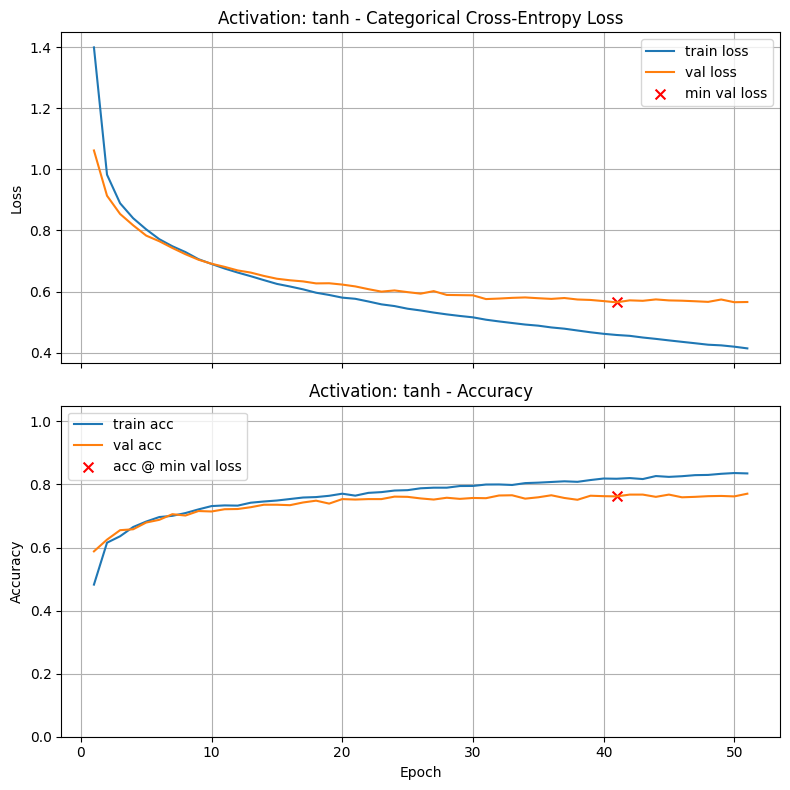

Final Training Loss:            0.4142
Final Training Accuracy:        0.8350
Final Validation Loss:          0.5660
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5649 (Epoch 41)
Validation Accuracy @ Min Loss: 0.7621

Test Loss: 0.5797
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:09


In [34]:
# Your code here. Add as many cells as you need. 
for i, act in enumerate(['relu', 'sigmoid', 'tanh']):
    model_baseline = build_model(
        X_train.shape[1],
        [ (64, act, 0.0, 0.0), (32, act, 0.0, 0.0) ],
        n_classes
    )
    train_and_test(model_baseline, title=f"Activation: {act}")

In [35]:
print_results()

Activation: sigmoid                     	0.7736
Activation: relu                        	0.7693
Activation: tanh                        	0.7621


### Graded Questions

In [36]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [37]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 2


In [38]:
# Set a1b to the validation accuracy found by this best activation function

a1b = 0.7829            # Replace 0.0 with your answer

In [39]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7829


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



LR: 0.001



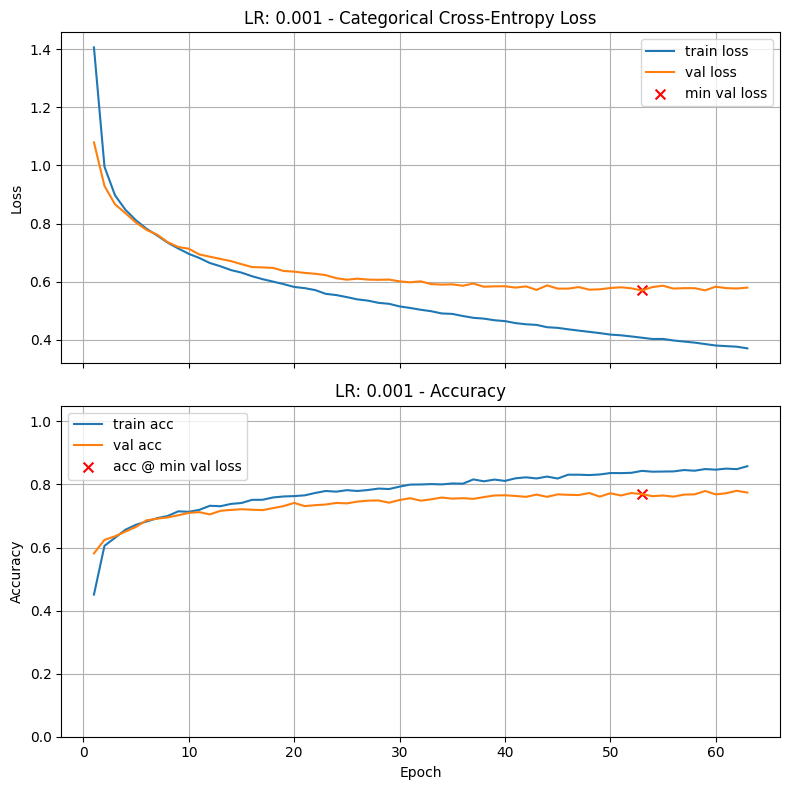

Final Training Loss:            0.3703
Final Training Accuracy:        0.8579
Final Validation Loss:          0.5794
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.5695 (Epoch 53)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.5902
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:11

LR: 0.0005



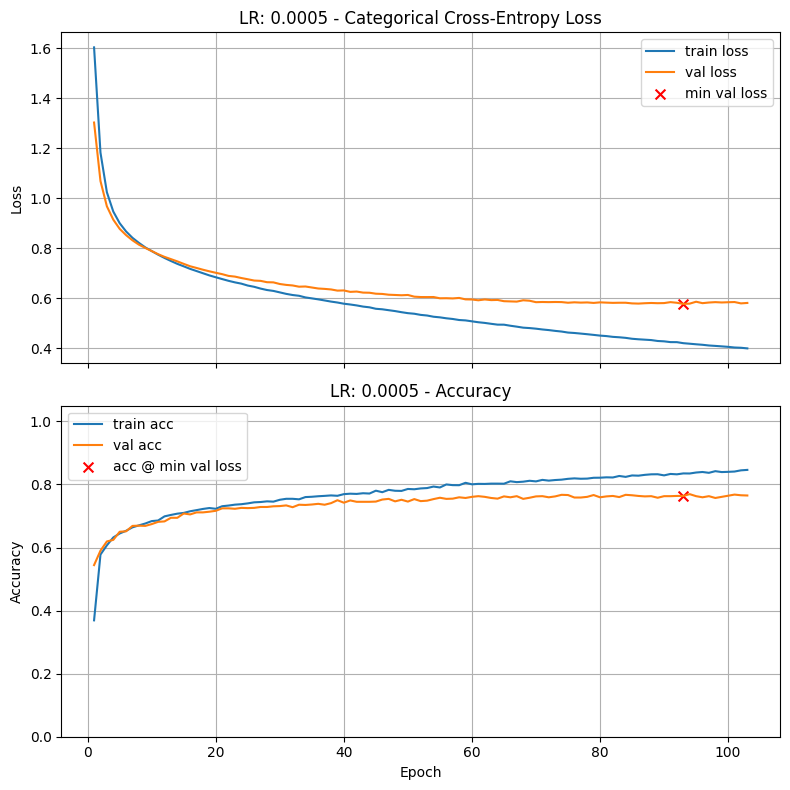

Final Training Loss:            0.3991
Final Training Accuracy:        0.8462
Final Validation Loss:          0.5810
Final Validation Accuracy:      0.7650
Minimum Validation Loss:        0.5771 (Epoch 93)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.5735
Test Accuracy: 0.7707

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:16

LR: 0.0001



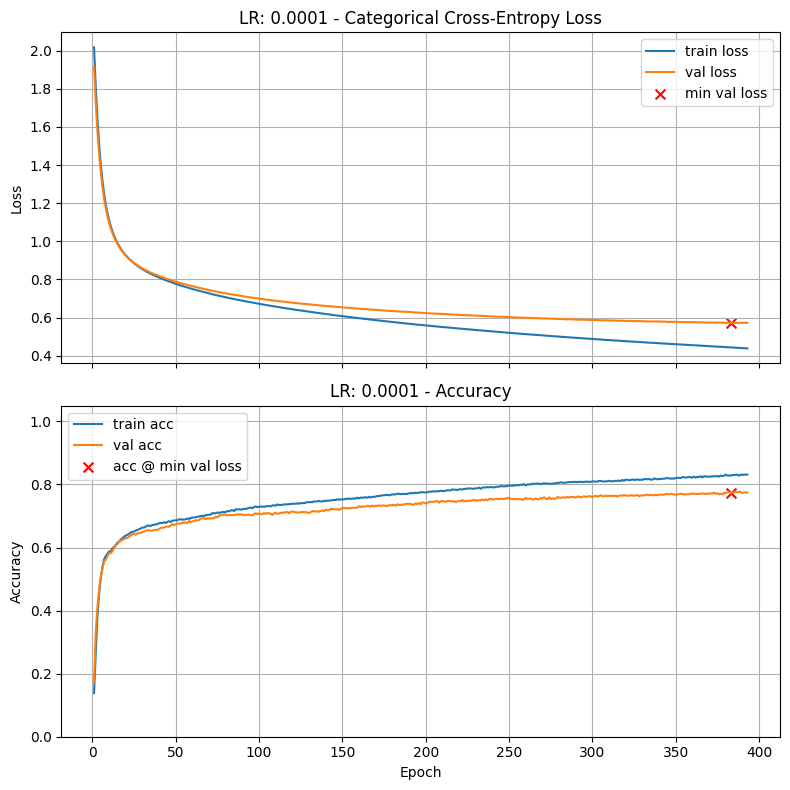

Final Training Loss:            0.4380
Final Training Accuracy:        0.8314
Final Validation Loss:          0.5715
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.5712 (Epoch 383)
Validation Accuracy @ Min Loss: 0.7721

Test Loss: 0.5827
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:59

LR: 5e-05



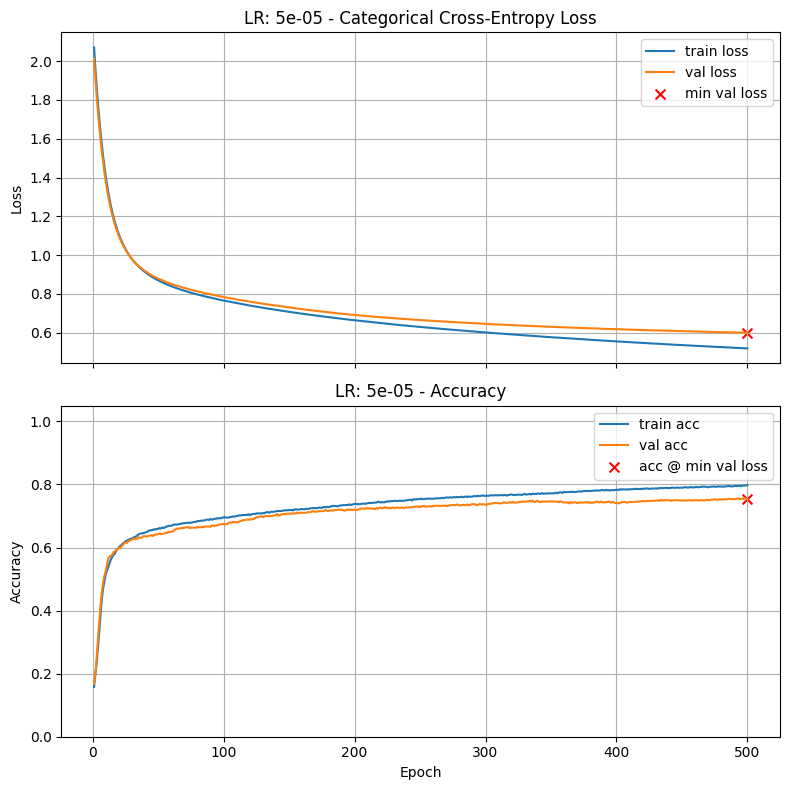

Final Training Loss:            0.5196
Final Training Accuracy:        0.7976
Final Validation Loss:          0.6002
Final Validation Accuracy:      0.7543
Minimum Validation Loss:        0.6002 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7543

Test Loss: 0.6260
Test Accuracy: 0.7421

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:01:16

LR: 1e-05



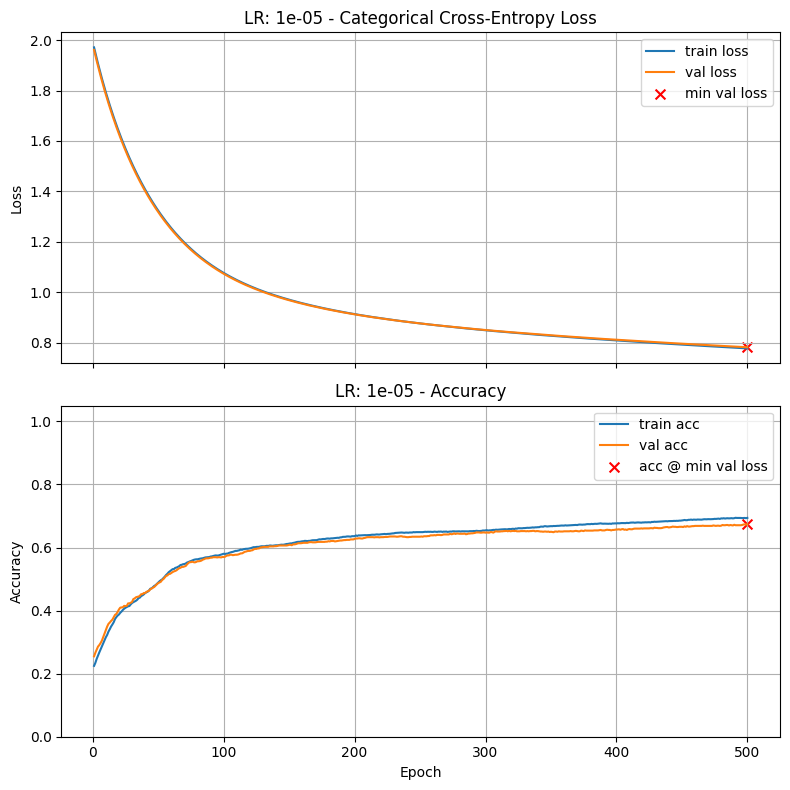

Final Training Loss:            0.7771
Final Training Accuracy:        0.6940
Final Validation Loss:          0.7816
Final Validation Accuracy:      0.6736
Minimum Validation Loss:        0.7816 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6736

Test Loss: 0.7944
Test Accuracy: 0.6879

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:01:16
Activation: sigmoid                     	0.7736
LR: 0.0001                              	0.7721
Activation: relu                        	0.7693
LR: 0.001                               	0.7693
LR: 0.0005                              	0.7636
Activation: tanh                        	0.7621
LR: 5e-05                               	0.7543
LR: 1e-05                               	0.6736


In [40]:
# Your code here. Add as many cells as you need. 
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

for lr in learning_rates:
    model_lr = build_model(
        X_train.shape[1],
        [ (64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0) ],
        n_classes
    )
    train_and_test(model_lr, lr_schedule=lr, title=f"LR: {lr}")
print_results()

#### Graded Questions

In [41]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 0.0001           # Replace 0.0 with your answer

In [42]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.000100


In [43]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = 0.7750             # Replace 0.0 with your answer

In [44]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7750


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Training model with dropout rates: 64=0.0, 32=0.0

Dropout: 64=0.0, 32=0.0



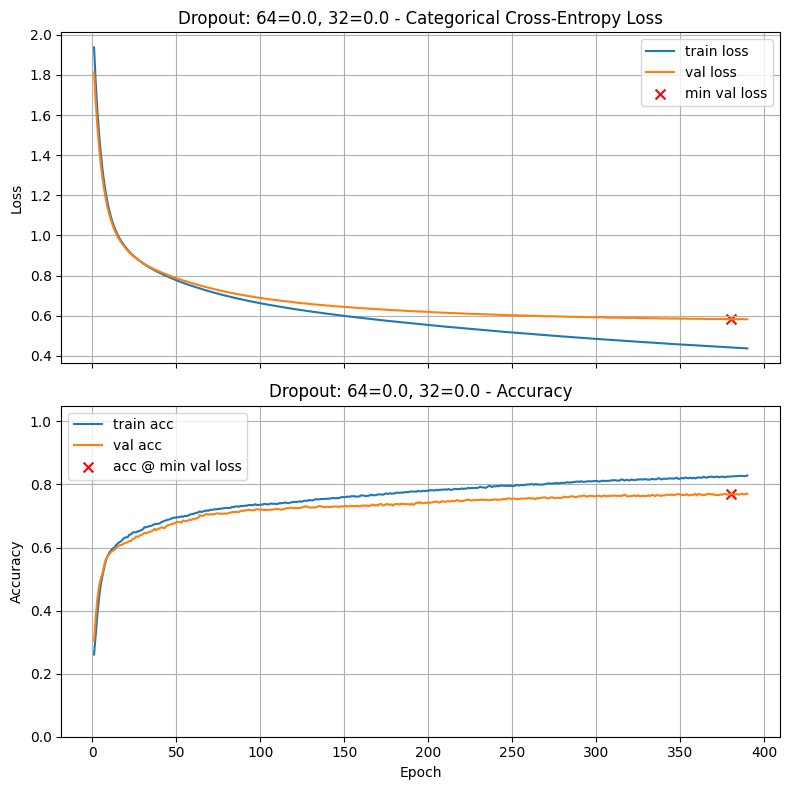

Final Training Loss:            0.4372
Final Training Accuracy:        0.8286
Final Validation Loss:          0.5823
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.5822 (Epoch 380)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.5853
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:59

Training model with dropout rates: 64=0.0, 32=0.1

Dropout: 64=0.0, 32=0.1



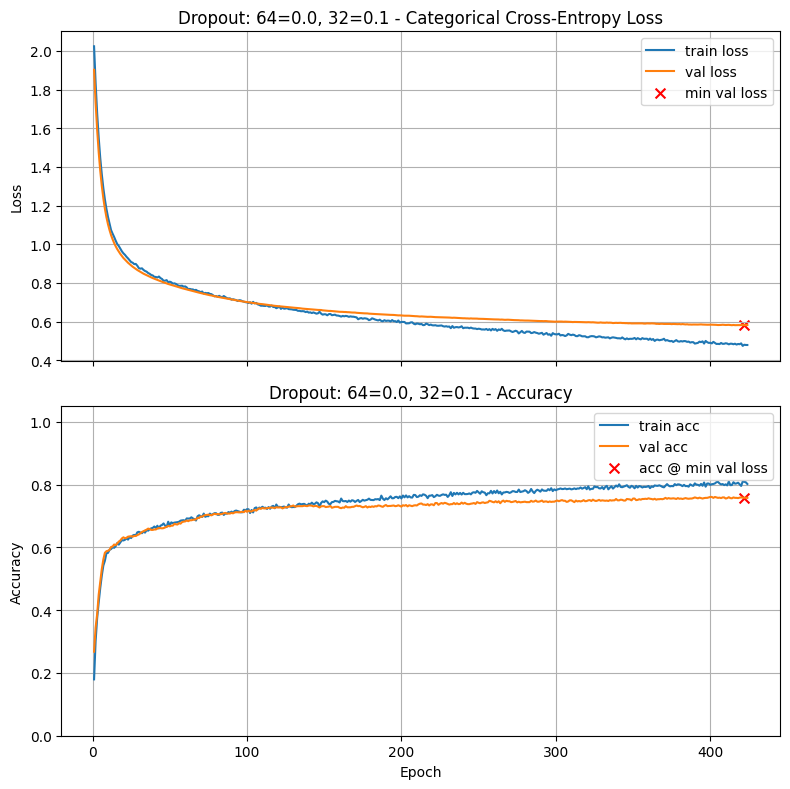

Final Training Loss:            0.4789
Final Training Accuracy:        0.8021
Final Validation Loss:          0.5822
Final Validation Accuracy:      0.7579
Minimum Validation Loss:        0.5812 (Epoch 422)
Validation Accuracy @ Min Loss: 0.7579

Test Loss: 0.5816
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:01:06

Training model with dropout rates: 64=0.0, 32=0.2

Dropout: 64=0.0, 32=0.2



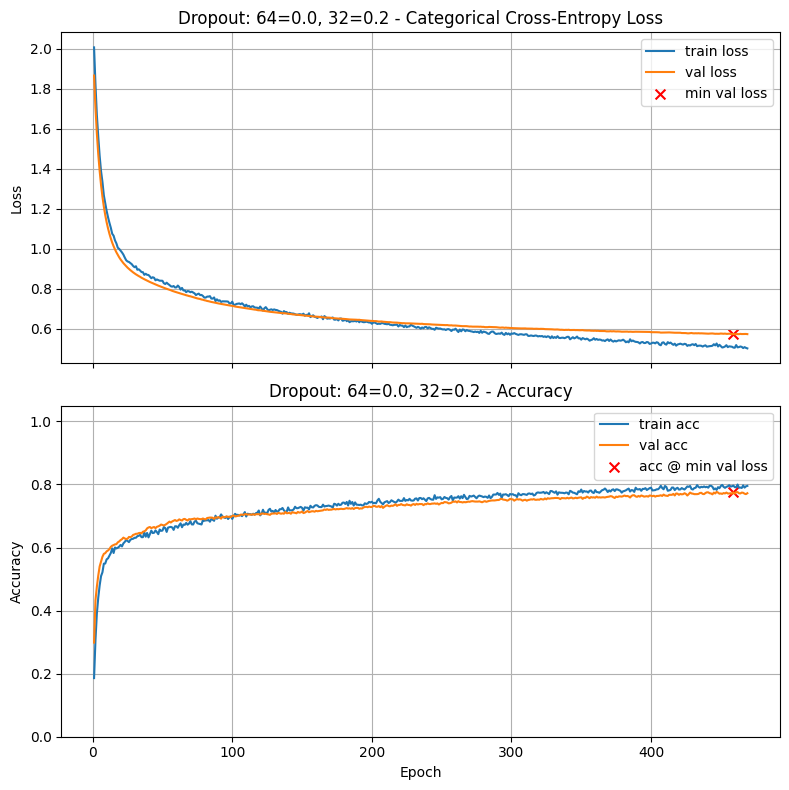

Final Training Loss:            0.5013
Final Training Accuracy:        0.7955
Final Validation Loss:          0.5726
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.5723 (Epoch 459)
Validation Accuracy @ Min Loss: 0.7750

Test Loss: 0.5990
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:01:14

Training model with dropout rates: 64=0.0, 32=0.3

Dropout: 64=0.0, 32=0.3



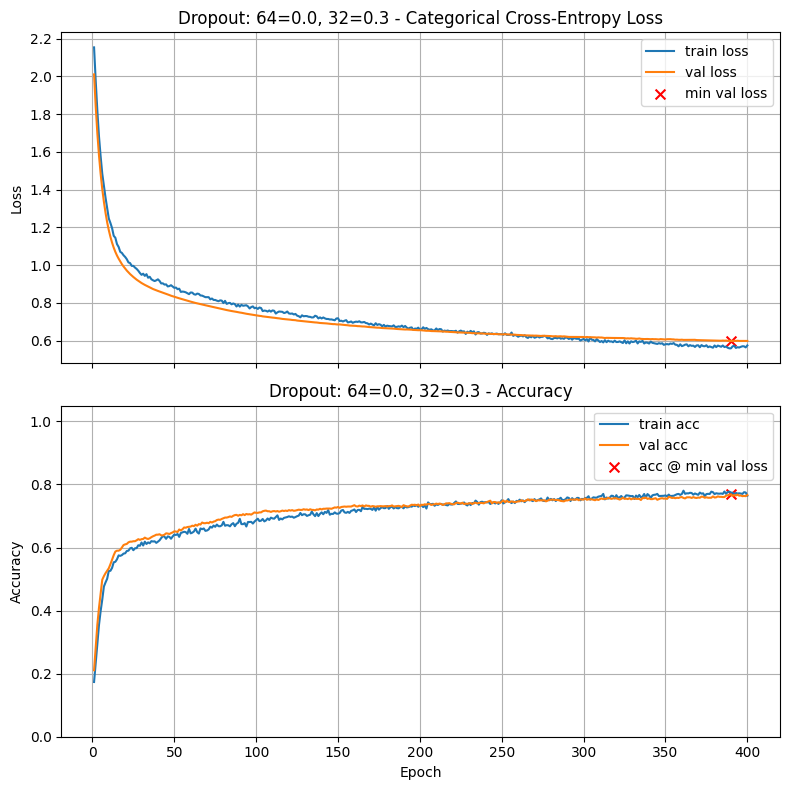

Final Training Loss:            0.5739
Final Training Accuracy:        0.7645
Final Validation Loss:          0.5978
Final Validation Accuracy:      0.7664
Minimum Validation Loss:        0.5973 (Epoch 390)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.6196
Test Accuracy: 0.7429

Validation-Test Gap (accuracy): 0.025714

Execution Time: 00:01:02

Training model with dropout rates: 64=0.0, 32=0.4

Dropout: 64=0.0, 32=0.4



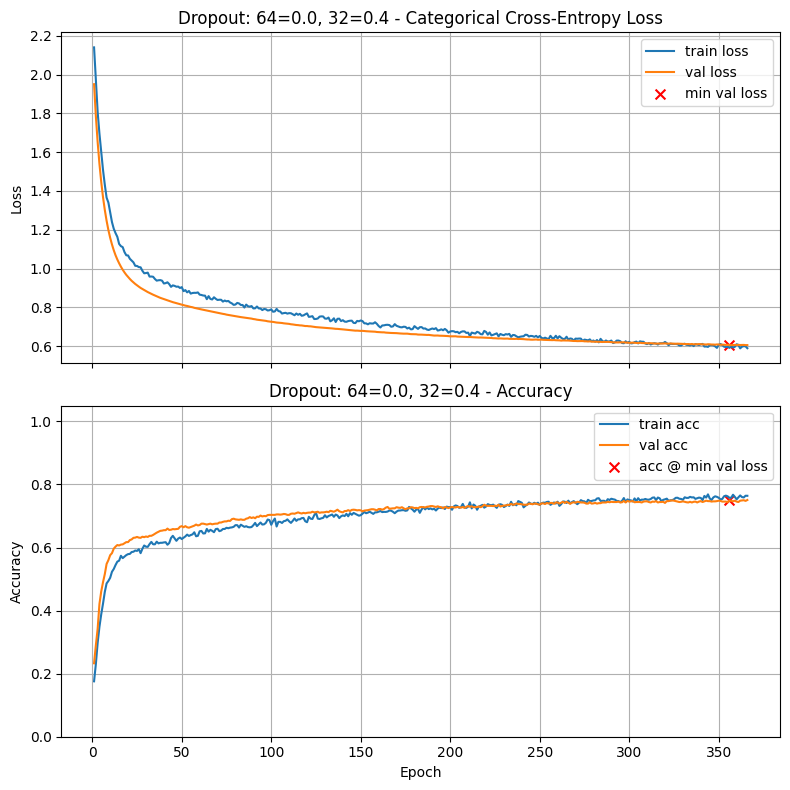

Final Training Loss:            0.5896
Final Training Accuracy:        0.7640
Final Validation Loss:          0.6056
Final Validation Accuracy:      0.7507
Minimum Validation Loss:        0.6054 (Epoch 356)
Validation Accuracy @ Min Loss: 0.7493

Test Loss: 0.6288
Test Accuracy: 0.7357

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:57

Training model with dropout rates: 64=0.0, 32=0.5

Dropout: 64=0.0, 32=0.5



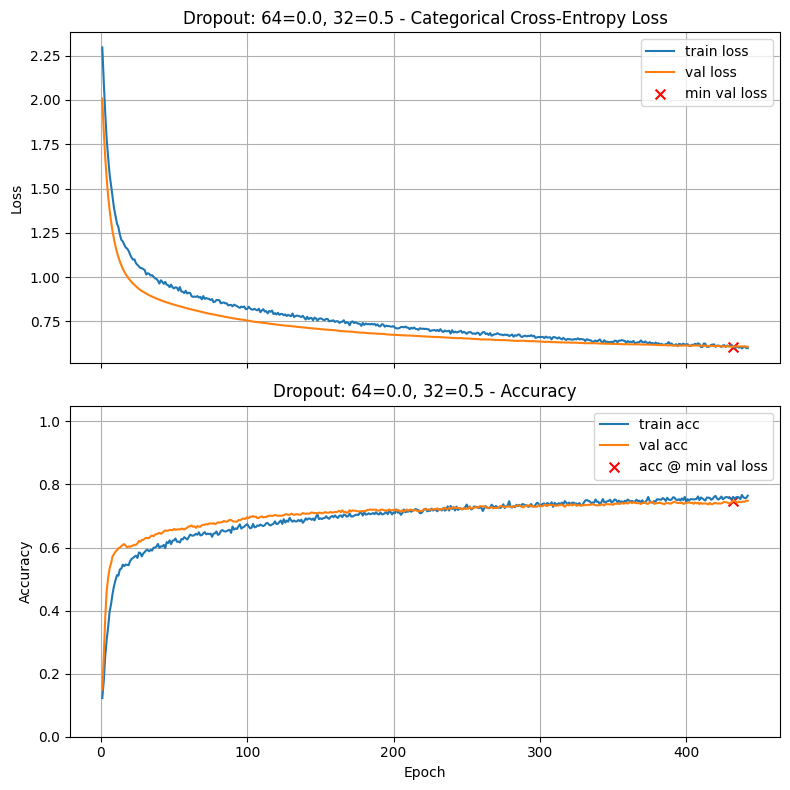

Final Training Loss:            0.5994
Final Training Accuracy:        0.7643
Final Validation Loss:          0.6073
Final Validation Accuracy:      0.7479
Minimum Validation Loss:        0.6072 (Epoch 432)
Validation Accuracy @ Min Loss: 0.7486

Test Loss: 0.6400
Test Accuracy: 0.7321

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:01:08

Training model with dropout rates: 64=0.1, 32=0.0

Dropout: 64=0.1, 32=0.0



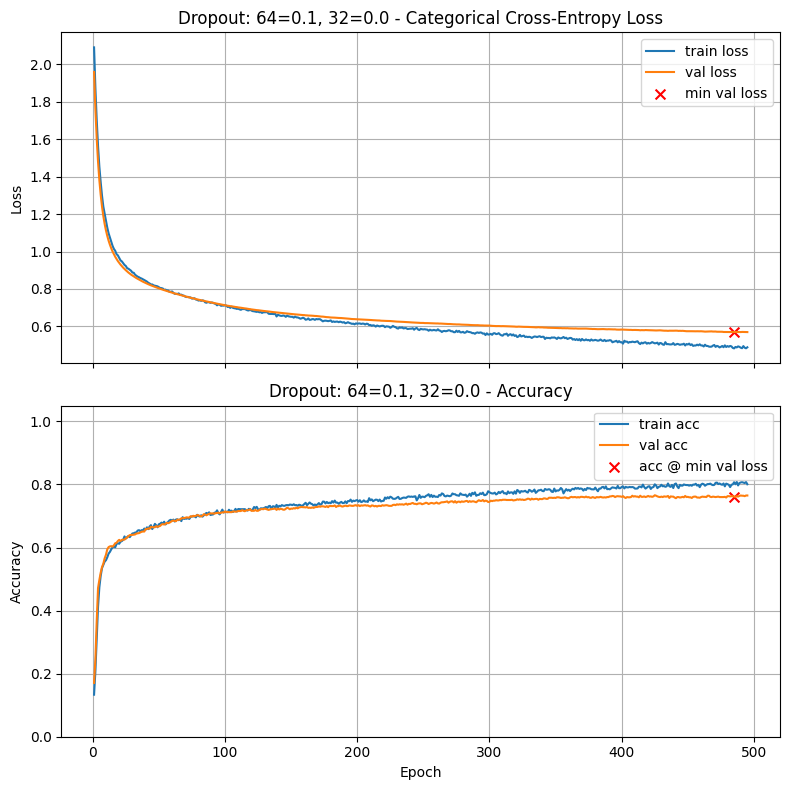

Final Training Loss:            0.4878
Final Training Accuracy:        0.8007
Final Validation Loss:          0.5692
Final Validation Accuracy:      0.7650
Minimum Validation Loss:        0.5691 (Epoch 485)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 0.5765
Test Accuracy: 0.7479

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:01:17

Training model with dropout rates: 64=0.1, 32=0.1

Dropout: 64=0.1, 32=0.1



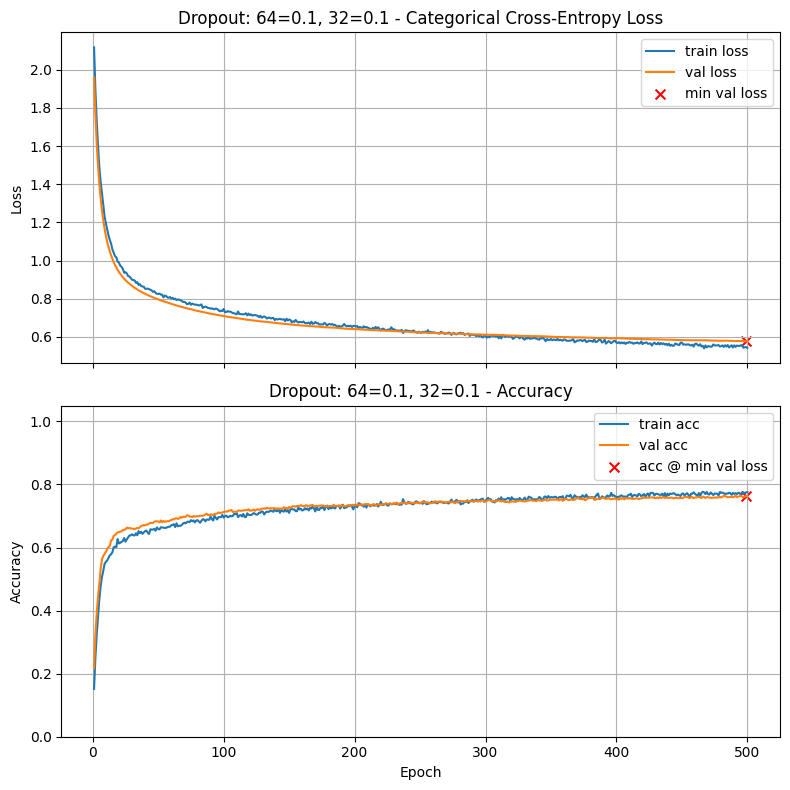

Final Training Loss:            0.5420
Final Training Accuracy:        0.7752
Final Validation Loss:          0.5776
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5770 (Epoch 499)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.6078
Test Accuracy: 0.7500

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:01:20

Training model with dropout rates: 64=0.1, 32=0.2

Dropout: 64=0.1, 32=0.2



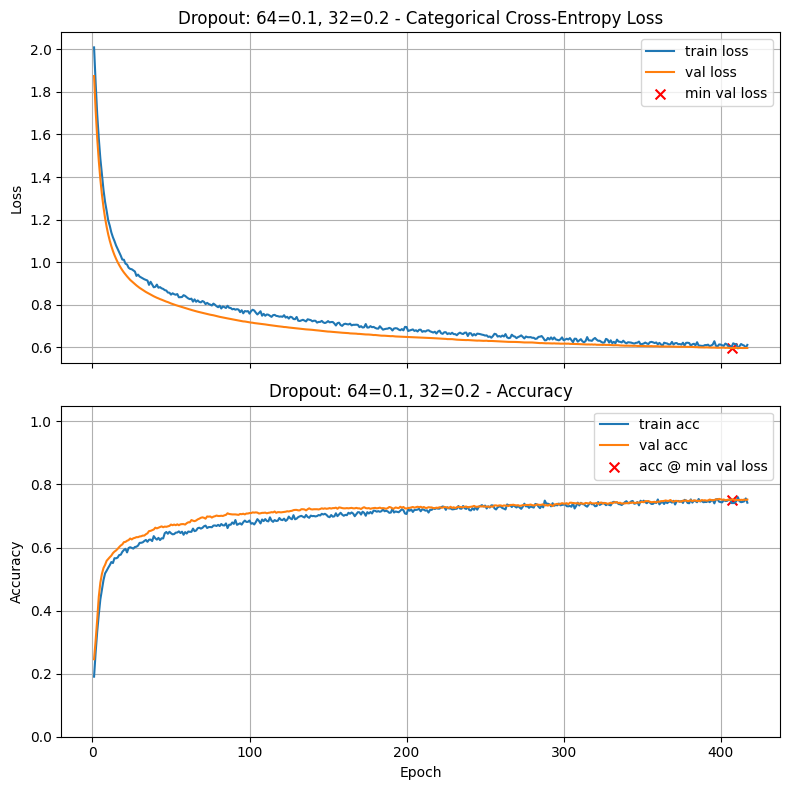

Final Training Loss:            0.6111
Final Training Accuracy:        0.7421
Final Validation Loss:          0.5967
Final Validation Accuracy:      0.7521
Minimum Validation Loss:        0.5962 (Epoch 407)
Validation Accuracy @ Min Loss: 0.7521

Test Loss: 0.6206
Test Accuracy: 0.7450

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:01:08

Training model with dropout rates: 64=0.1, 32=0.3

Dropout: 64=0.1, 32=0.3



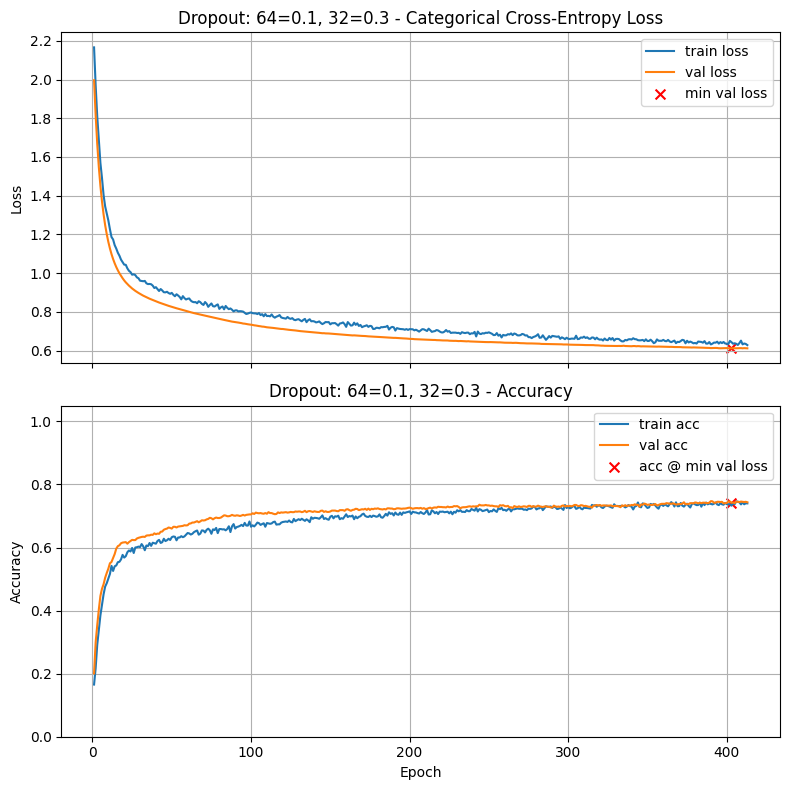

Final Training Loss:            0.6280
Final Training Accuracy:        0.7400
Final Validation Loss:          0.6113
Final Validation Accuracy:      0.7436
Minimum Validation Loss:        0.6110 (Epoch 403)
Validation Accuracy @ Min Loss: 0.7421

Test Loss: 0.6431
Test Accuracy: 0.7329

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:01:08

Training model with dropout rates: 64=0.1, 32=0.4

Dropout: 64=0.1, 32=0.4



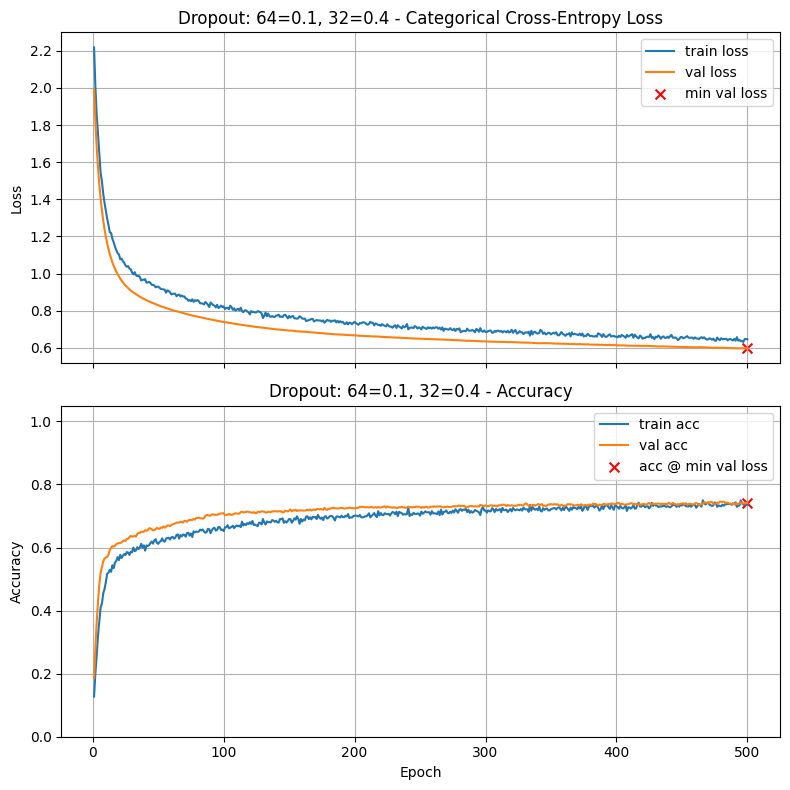

Final Training Loss:            0.6467
Final Training Accuracy:        0.7360
Final Validation Loss:          0.5975
Final Validation Accuracy:      0.7421
Minimum Validation Loss:        0.5975 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7421

Test Loss: 0.6328
Test Accuracy: 0.7414

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:01:21

Training model with dropout rates: 64=0.1, 32=0.5

Dropout: 64=0.1, 32=0.5



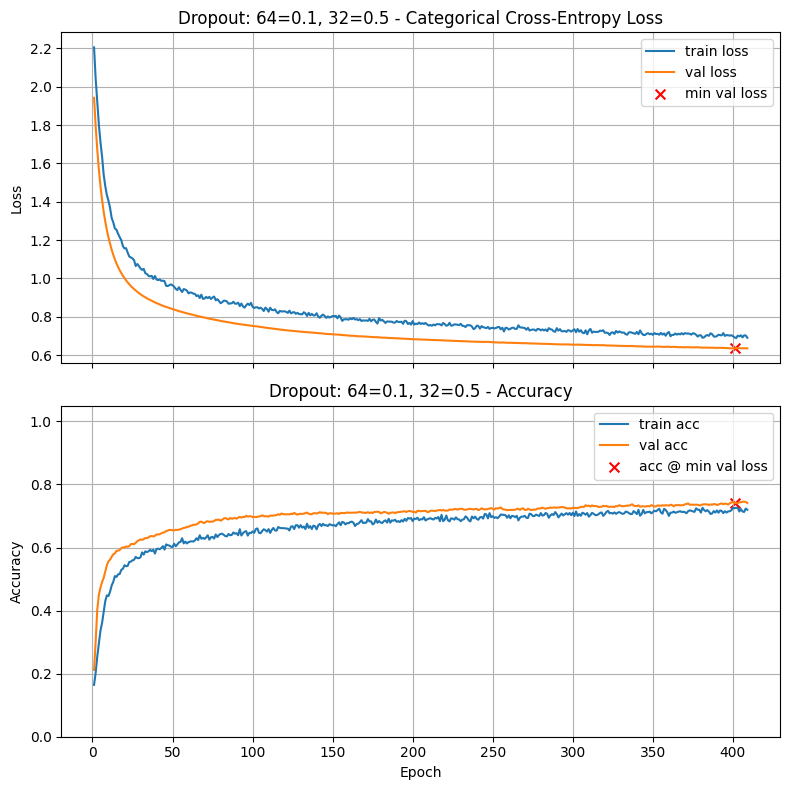

Final Training Loss:            0.6908
Final Training Accuracy:        0.7198
Final Validation Loss:          0.6358
Final Validation Accuracy:      0.7414
Minimum Validation Loss:        0.6355 (Epoch 401)
Validation Accuracy @ Min Loss: 0.7414

Test Loss: 0.6628
Test Accuracy: 0.7293

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:01:06

Training model with dropout rates: 64=0.2, 32=0.0

Dropout: 64=0.2, 32=0.0



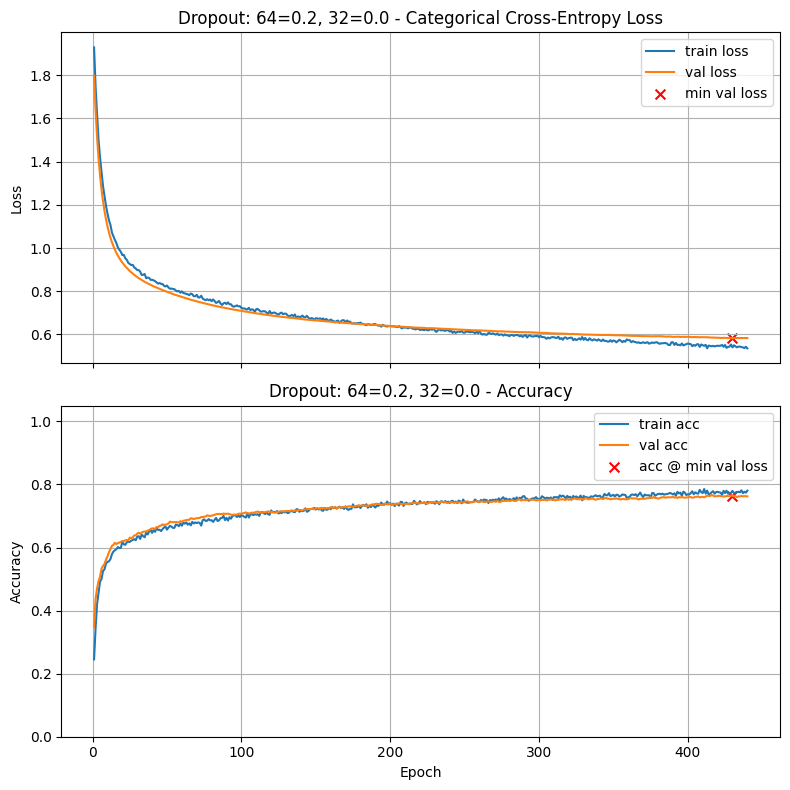

Final Training Loss:            0.5355
Final Training Accuracy:        0.7805
Final Validation Loss:          0.5833
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.5826 (Epoch 430)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.6090
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:01:09

Training model with dropout rates: 64=0.2, 32=0.1

Dropout: 64=0.2, 32=0.1



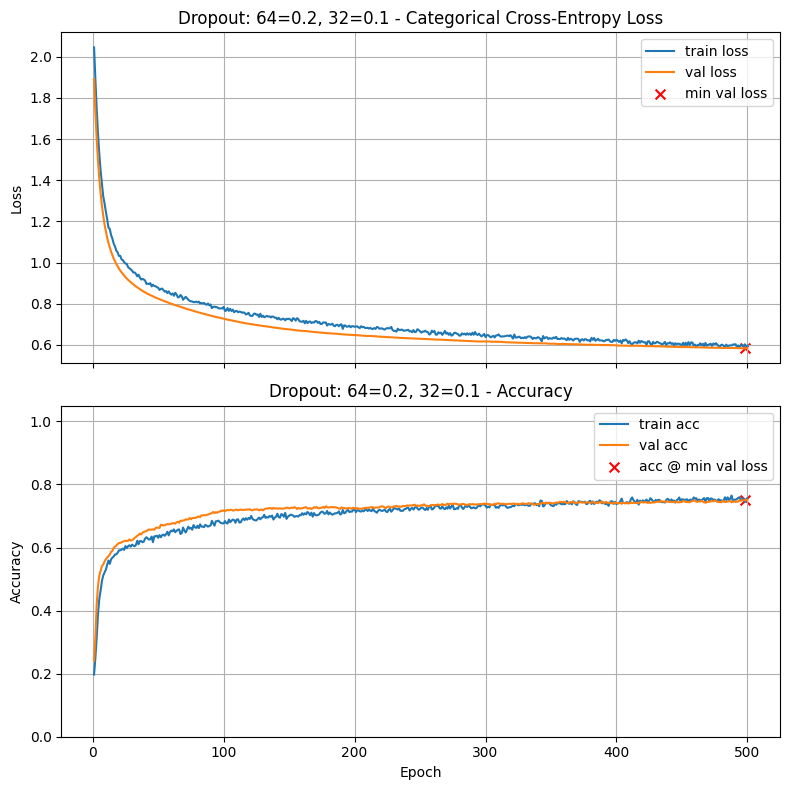

Final Training Loss:            0.5959
Final Training Accuracy:        0.7562
Final Validation Loss:          0.5833
Final Validation Accuracy:      0.7514
Minimum Validation Loss:        0.5830 (Epoch 498)
Validation Accuracy @ Min Loss: 0.7507

Test Loss: 0.6162
Test Accuracy: 0.7371

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:01:20

Training model with dropout rates: 64=0.2, 32=0.2

Dropout: 64=0.2, 32=0.2



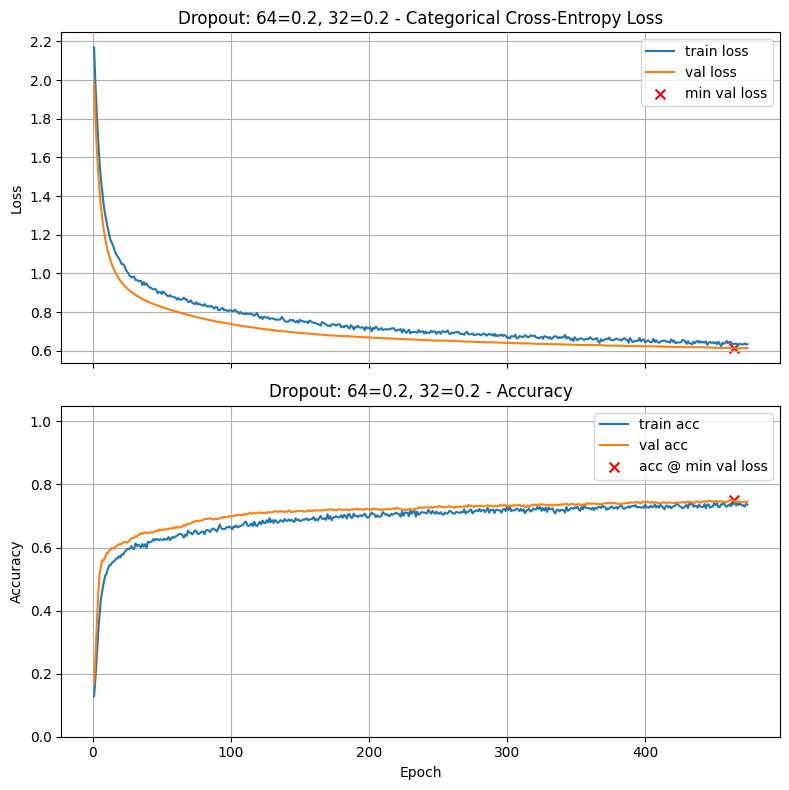

Final Training Loss:            0.6343
Final Training Accuracy:        0.7357
Final Validation Loss:          0.6139
Final Validation Accuracy:      0.7457
Minimum Validation Loss:        0.6124 (Epoch 464)
Validation Accuracy @ Min Loss: 0.7493

Test Loss: 0.6336
Test Accuracy: 0.7350

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:01:15

Training model with dropout rates: 64=0.2, 32=0.3

Dropout: 64=0.2, 32=0.3



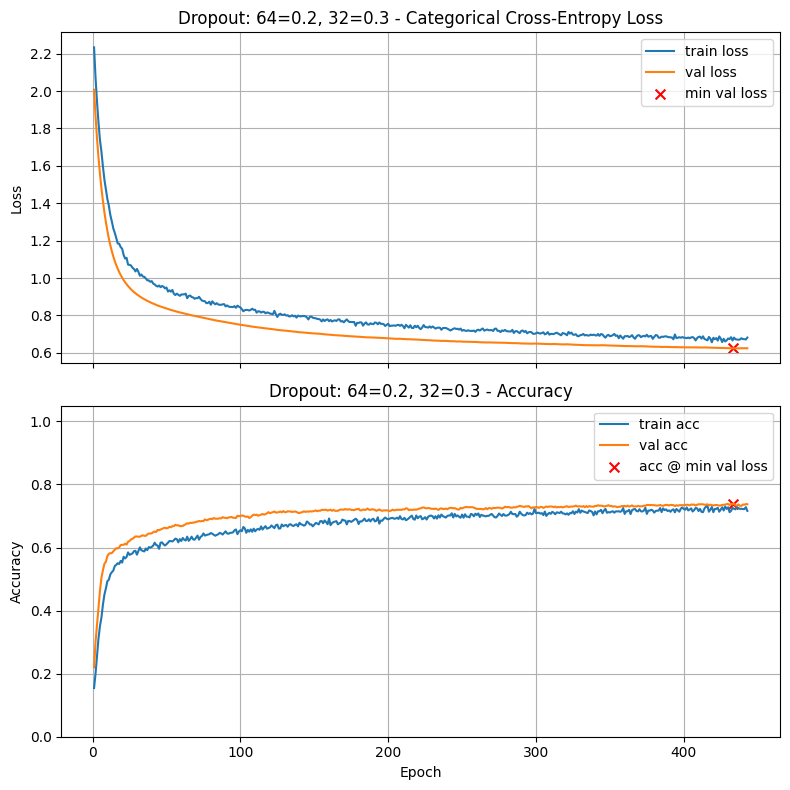

Final Training Loss:            0.6815
Final Training Accuracy:        0.7162
Final Validation Loss:          0.6239
Final Validation Accuracy:      0.7371
Minimum Validation Loss:        0.6236 (Epoch 433)
Validation Accuracy @ Min Loss: 0.7371

Test Loss: 0.6521
Test Accuracy: 0.7307

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:01:11

Training model with dropout rates: 64=0.2, 32=0.4

Dropout: 64=0.2, 32=0.4



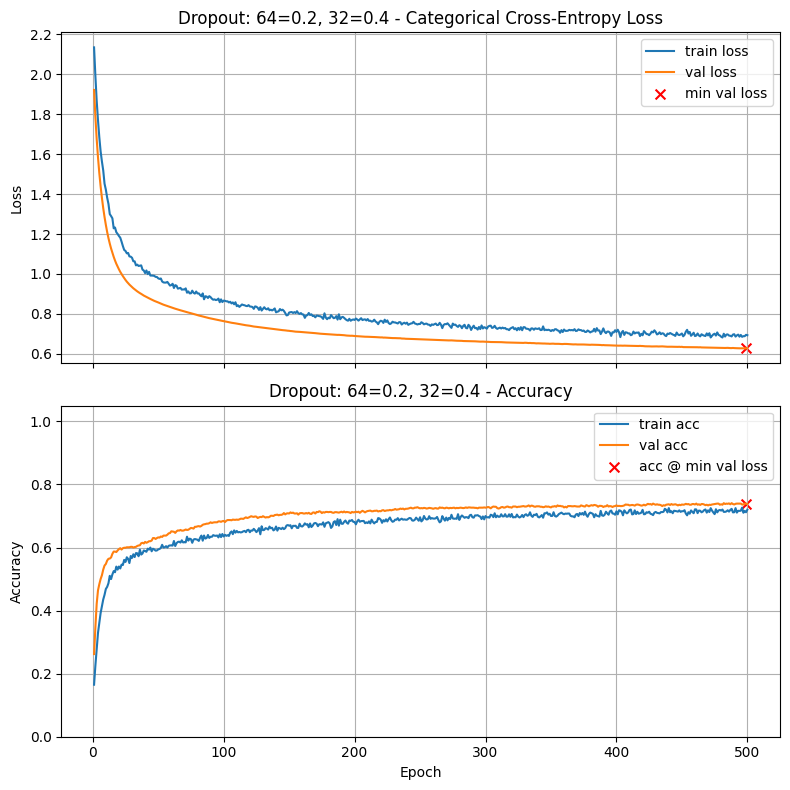

Final Training Loss:            0.6932
Final Training Accuracy:        0.7200
Final Validation Loss:          0.6275
Final Validation Accuracy:      0.7386
Minimum Validation Loss:        0.6272 (Epoch 499)
Validation Accuracy @ Min Loss: 0.7386

Test Loss: 0.6524
Test Accuracy: 0.7329

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:01:21

Training model with dropout rates: 64=0.2, 32=0.5

Dropout: 64=0.2, 32=0.5



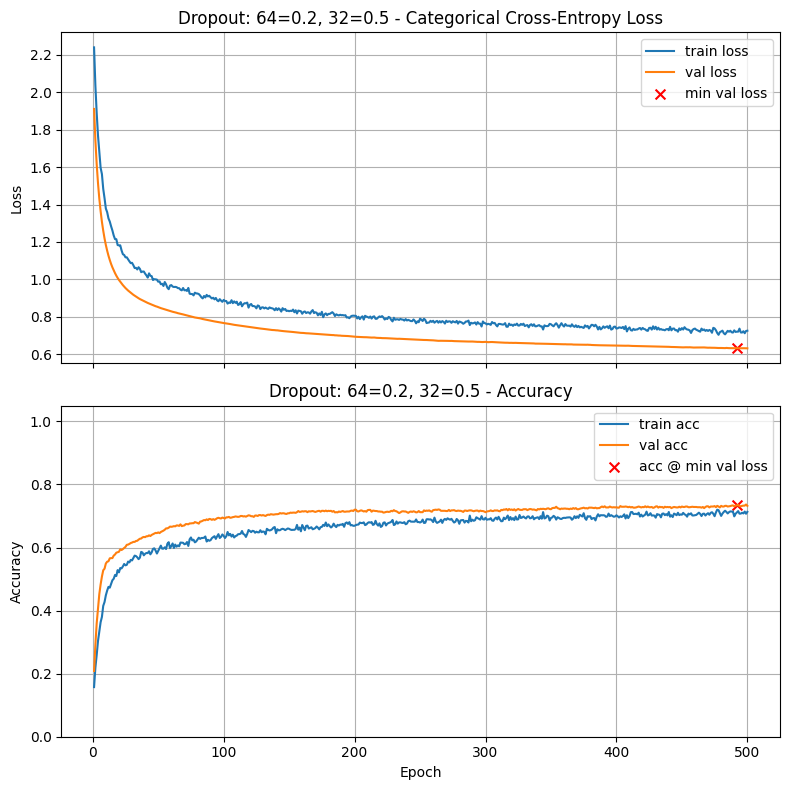

Final Training Loss:            0.7249
Final Training Accuracy:        0.7131
Final Validation Loss:          0.6308
Final Validation Accuracy:      0.7321
Minimum Validation Loss:        0.6304 (Epoch 492)
Validation Accuracy @ Min Loss: 0.7336

Test Loss: 0.6655
Test Accuracy: 0.7271

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:01:24
Dropout: 64=0.0, 32=0.2                 	0.7750
Activation: sigmoid                     	0.7736
LR: 0.0001                              	0.7721
Activation: relu                        	0.7693
LR: 0.001                               	0.7693
Dropout: 64=0.0, 32=0.0                 	0.7686
Dropout: 64=0.0, 32=0.3                 	0.7686
Dropout: 64=0.2, 32=0.0                 	0.7643
LR: 0.0005                              	0.7636
Dropout: 64=0.1, 32=0.1                 	0.7636
Activation: tanh                        	0.7621
Dropout: 64=0.1, 32=0.0                 	0.7614
Dropout: 64=0.0, 32=0.1                 	0.7579
LR: 5e-05            

In [46]:
# Track best results
best_acc = 0
best_dropout = None

# Dropout ranges for each layer
dropout_64_values = [0.0, 0.1, 0.2]             # for 64-unit layer
dropout_32_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  # for 32-unit layer

for d1 in dropout_64_values:
    for d2 in dropout_32_values:
        model_do = build_model(
            X_train.shape[1],
            [ (64, 'tanh', 0.0, d1), (32, 'tanh', 0.0, d2) ],
            n_classes
        )
        title = f"Dropout: 64={d1}, 32={d2}"
        print(f"\nTraining model with dropout rates: 64={d1}, 32={d2}")
        train_and_test(model_do, lr_schedule=0.0001, title=title)

# After all runs:
print_results()


In [47]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.0, 0.2)              # Replace (0.0,0.0) with your answer

In [48]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.0, 0.2)


In [49]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b =  0.7750             # Replace 0.0 with your answer

In [50]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7750


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Training model with L2 lambdas: 64=0.0001, 32=0.0001

L2: 64=0.0001, 32=0.0001



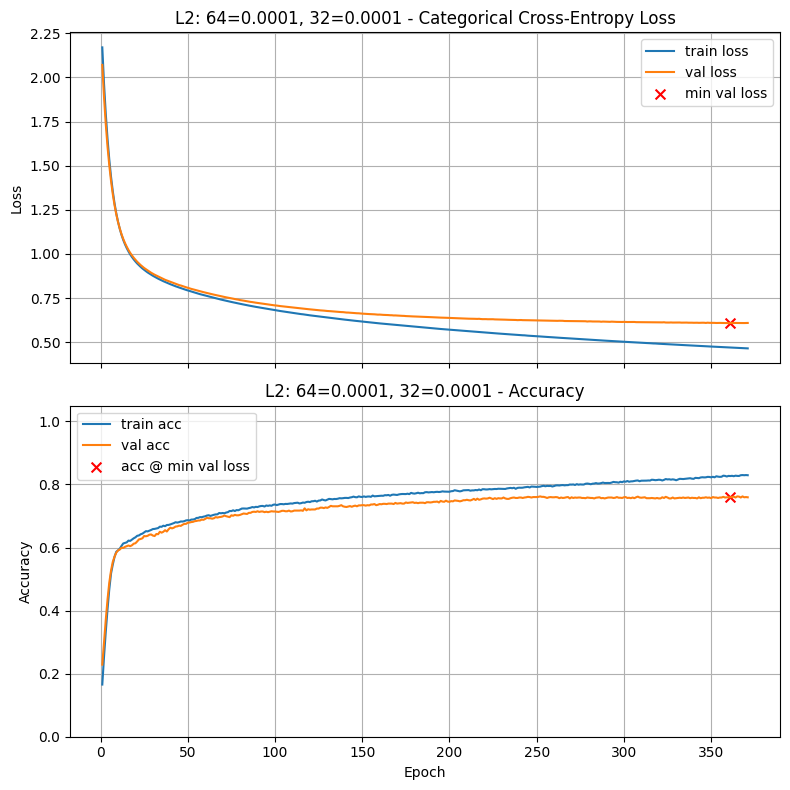

Final Training Loss:            0.4651
Final Training Accuracy:        0.8293
Final Validation Loss:          0.6091
Final Validation Accuracy:      0.7593
Minimum Validation Loss:        0.6080 (Epoch 361)
Validation Accuracy @ Min Loss: 0.7593

Test Loss: 0.6191
Test Accuracy: 0.7536

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:59

Training model with L2 lambdas: 64=0.001, 32=0.001

L2: 64=0.001, 32=0.001



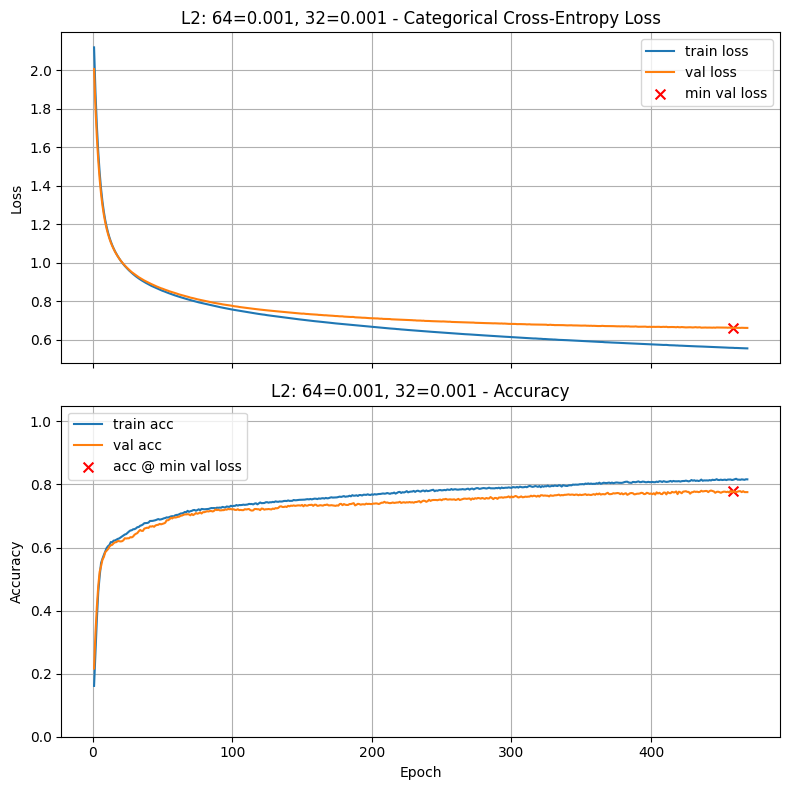

Final Training Loss:            0.5553
Final Training Accuracy:        0.8162
Final Validation Loss:          0.6616
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.6616 (Epoch 459)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.6774
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:01:12

Training model with L2 lambdas: 64=0.01, 32=0.01

L2: 64=0.01, 32=0.01



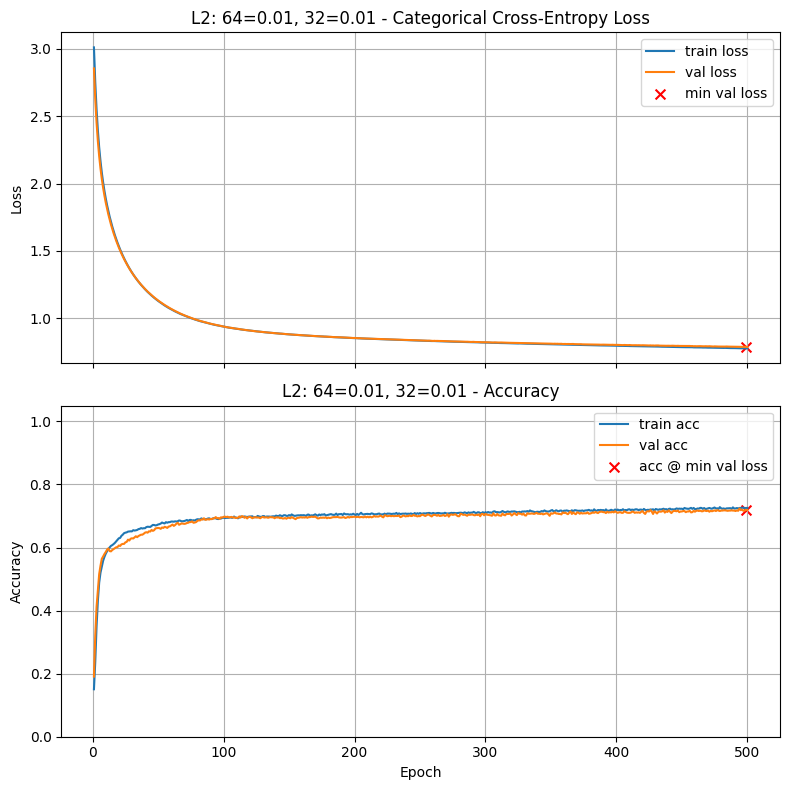

Final Training Loss:            0.7777
Final Training Accuracy:        0.7255
Final Validation Loss:          0.7885
Final Validation Accuracy:      0.7186
Minimum Validation Loss:        0.7882 (Epoch 499)
Validation Accuracy @ Min Loss: 0.7200

Test Loss: 0.8080
Test Accuracy: 0.7093

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:01:16

Training model with L2 lambdas: 64=0.0001, 32=0.001

L2: 64=0.0001, 32=0.001



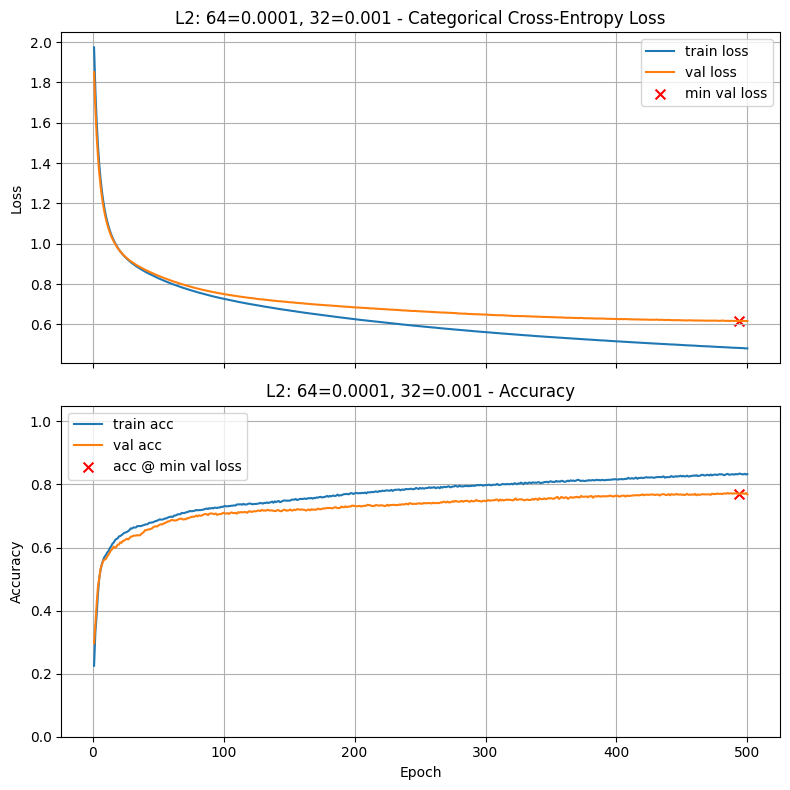

Final Training Loss:            0.4810
Final Training Accuracy:        0.8329
Final Validation Loss:          0.6168
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.6164 (Epoch 494)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.6359
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:01:17
L2: 64=0.001, 32=0.001                  	0.7793
Dropout: 64=0.0, 32=0.2                 	0.7750
Activation: sigmoid                     	0.7736
LR: 0.0001                              	0.7721
L2: 64=0.0001, 32=0.001                 	0.7700
Activation: relu                        	0.7693
LR: 0.001                               	0.7693
Dropout: 64=0.0, 32=0.0                 	0.7686
Dropout: 64=0.0, 32=0.3                 	0.7686
Dropout: 64=0.2, 32=0.0                 	0.7643
LR: 0.0005                              	0.7636
Dropout: 64=0.1, 32=0.1                 	0.7636
Activation: tanh                        	0.7621
Dropout: 64=0.1, 32=0

In [51]:
# Your code here. Add as many cells as you need. 
l2_combos = [
    (1e-4, 1e-4),
    (1e-3, 1e-3),
    (1e-2, 1e-2),
    (1e-4, 1e-3)
]

for l2_64, l2_32 in l2_combos:
    model_l2 = build_model(
        X_train.shape[1],
        [ (64, 'tanh', l2_64, 0.0), (32, 'tanh', l2_32, 0.0) ],
        n_classes
    )
    title = f"L2: 64={l2_64}, 32={l2_32}"
    print(f"\nTraining model with L2 lambdas: 64={l2_64}, 32={l2_32}")
    train_and_test(model_l2, lr_schedule=0.0001, title=title)

# After all runs
print_results()


In [52]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (0.001, 0.001)            # Replace (0.0,0.0) with your answer

In [53]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.001, 0.001)


In [54]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.7793               # Replace 0.0 with your answer

In [55]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7793


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



In [60]:
results = {}  # ✅ Must be a dictionary, not a list


In [64]:
def plot_learning_curves(history, title="", verbose=True):
    min_val_epoch = np.argmin(history.history['val_loss'])
    min_val_loss = history.history['val_loss'][min_val_epoch]
    if verbose:
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {history.history['val_accuracy'][min_val_epoch]:.4f}")

    # ✅ Store results using the same style as earlier problems
    results[title] = (history.history['val_accuracy'][min_val_epoch], min_val_epoch + 1)


In [65]:
# Problem 5: Combine best dropout and L2 regularization

activation_best = 'tanh'              # From Problem 1
learning_rate_best = 0.0001           # From Problem 2
dropout_best = (0.0, 0.2)             # From Problem 3
l2_values = [1e-4, 1e-3, 1e-2]        # L2 values to test

# Clear old results
results.clear()

# Store results in a list of tuples (title, val_accuracy)
run_results = []

# First round: fixed dropout, varying L2
for l2 in l2_values:
    title = f"Dropout={dropout_best}, L2={l2}"
    model = build_model(
        X_train.shape[1],
        [
            (64, activation_best, l2, dropout_best[0]),
            (32, activation_best, l2, dropout_best[1])
        ],
        n_classes
    )
    train_and_test(model, lr_schedule=learning_rate_best, title=title)
    acc = results[title][0]
    run_results.append((title, acc))

# Second round: slightly reduced dropout, same L2 values
dropout_reduced = (max(0.0, dropout_best[0] - 0.1), max(0.0, dropout_best[1] - 0.1))

for l2 in l2_values:
    title = f"Reduced Dropout={dropout_reduced}, L2={l2}"
    model = build_model(
        X_train.shape[1],
        [
            (64, activation_best, l2, dropout_reduced[0]),
            (32, activation_best, l2, dropout_reduced[1])
        ],
        n_classes
    )
    train_and_test(model, lr_schedule=learning_rate_best, title=title)
    acc = results[title][0]
    run_results.append((title, acc))

# Find best accuracy and configuration
best_title, best_acc = max(run_results, key=lambda x: x[1])

# Report
print(f"\nBest configuration:\n{best_title}")
print(f"Validation accuracy: {best_acc:.4f}")


Dropout=(0.0, 0.2), L2=0.0001

Minimum Validation Loss:        0.6060 (Epoch 381)
Validation Accuracy @ Min Loss: 0.7621

Test Loss: 0.6263
Test Accuracy: 0.7429

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:01:04

Dropout=(0.0, 0.2), L2=0.001

Minimum Validation Loss:        0.6819 (Epoch 440)
Validation Accuracy @ Min Loss: 0.7550

Test Loss: 0.7006
Test Accuracy: 0.7436

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:01:12

Dropout=(0.0, 0.2), L2=0.01

Minimum Validation Loss:        0.8023 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7000

Test Loss: 0.8253
Test Accuracy: 0.7114

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:01:21

Reduced Dropout=(0.0, 0.1), L2=0.0001

Minimum Validation Loss:        0.5865 (Epoch 442)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.6051
Test Accuracy: 0.7607

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:01:11

Reduced Dropout=(0.0, 0.1), L2=0.001

Minimum Validation Loss:        

In [66]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.7671               # Replace 0.0 with your answer

In [67]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7671


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks


dropout_best = (0.0, 0.1)       
l2_best = 0.0001                
activation_best = 'relu'        
batch_size = 64               
initial_learning_rate = 0.001   
decay_rate = 0.95             
decay_steps = 100             

# Build model function, same as before (adjust if needed)
def build_model(input_dim, layer_params, n_classes):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for i, (width, activation, l2_val, dropout_val) in enumerate(layer_params):
        model.add(layers.Dense(width,
                               activation=activation,
                               kernel_regularizer=regularizers.l2(l2_val)))
        if dropout_val > 0:
            model.add(layers.Dropout(dropout_val))
    
    model.add(layers.Dense(n_classes, activation='softmax'))
    return model


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)


model_best = build_model(
    X_train.shape[1],
    [
        (64, activation_best, l2_best, dropout_best[0]),
        (32, activation_best, l2_best, dropout_best[1])
    ],
    n_classes
)


model_best.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model_best.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=2
)


val_loss_history = history.history['val_loss']
min_val_loss_epoch = val_loss_history.index(min(val_loss_history))
a6 = history.history['val_accuracy'][min_val_loss_epoch]

print(f'a6 = {a6:.4f}')



Epoch 1/500
66/66 - 2s - 30ms/step - accuracy: 0.3710 - loss: 1.7077 - val_accuracy: 0.5350 - val_loss: 1.3638
Epoch 2/500
66/66 - 0s - 4ms/step - accuracy: 0.5643 - loss: 1.2068 - val_accuracy: 0.5986 - val_loss: 1.0179
Epoch 3/500
66/66 - 0s - 5ms/step - accuracy: 0.6071 - loss: 1.0107 - val_accuracy: 0.6307 - val_loss: 0.9068
Epoch 4/500
66/66 - 0s - 6ms/step - accuracy: 0.6321 - loss: 0.9316 - val_accuracy: 0.6679 - val_loss: 0.8626
Epoch 5/500
66/66 - 0s - 3ms/step - accuracy: 0.6429 - loss: 0.8914 - val_accuracy: 0.6729 - val_loss: 0.8268
Epoch 6/500
66/66 - 0s - 5ms/step - accuracy: 0.6521 - loss: 0.8677 - val_accuracy: 0.6850 - val_loss: 0.8057
Epoch 7/500
66/66 - 0s - 5ms/step - accuracy: 0.6683 - loss: 0.8338 - val_accuracy: 0.6943 - val_loss: 0.7881
Epoch 8/500
66/66 - 0s - 4ms/step - accuracy: 0.6743 - loss: 0.8198 - val_accuracy: 0.7050 - val_loss: 0.7700
Epoch 9/500
66/66 - 0s - 5ms/step - accuracy: 0.6857 - loss: 0.8006 - val_accuracy: 0.7136 - val_loss: 0.7564
Epoch 10/

In [71]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.7536             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.0000


### Optional: Print out your results of all experiments

In [ ]:
print_results()

## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?